In [64]:
import gc
import os
import string

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchinfo import summary

from collections import namedtuple
import PyPDF3

In [65]:
jtplot.style("gruvboxd")

In [66]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [67]:
device

device(type='cuda')

device(type='cuda')

In [68]:
SEED = 42

if device == "cuda":
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

In [69]:
DATA_DIR = os.getcwd().replace('notebooks', 'data')

with open(os.path.join(DATA_DIR, 'anna.txt'), 'r') as file:
    text = file.read()

In [70]:
text[:120]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in confusion i'

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in confusion i'

In [71]:
unique_chars = list(set(text))

In [72]:
len(unique_chars)

83

83

In [73]:
unique_chars

['S',
 'j',
 '/',
 'I',
 'B',
 'l',
 'R',
 '*',
 'i',
 '&',
 '%',
 '4',
 'r',
 'D',
 '\n',
 'W',
 '3',
 's',
 'y',
 '(',
 '$',
 '!',
 'g',
 'z',
 'w',
 '.',
 'L',
 'Z',
 'U',
 'k',
 ')',
 'x',
 '5',
 'd',
 '1',
 'a',
 'G',
 'c',
 ',',
 'A',
 '@',
 'H',
 'b',
 'X',
 'T',
 'K',
 'M',
 '9',
 'e',
 'n',
 '-',
 'O',
 '0',
 '7',
 'Y',
 'E',
 'o',
 'p',
 't',
 '8',
 'P',
 'f',
 'Q',
 'C',
 'V',
 '2',
 "'",
 '6',
 'm',
 'J',
 'v',
 ':',
 'h',
 '?',
 '_',
 '"',
 'N',
 '`',
 'F',
 ' ',
 'u',
 'q',
 ';']

['S',
 'j',
 '/',
 'I',
 'B',
 'l',
 'R',
 '*',
 'i',
 '&',
 '%',
 '4',
 'r',
 'D',
 '\n',
 'W',
 '3',
 's',
 'y',
 '(',
 '$',
 '!',
 'g',
 'z',
 'w',
 '.',
 'L',
 'Z',
 'U',
 'k',
 ')',
 'x',
 '5',
 'd',
 '1',
 'a',
 'G',
 'c',
 ',',
 'A',
 '@',
 'H',
 'b',
 'X',
 'T',
 'K',
 'M',
 '9',
 'e',
 'n',
 '-',
 'O',
 '0',
 '7',
 'Y',
 'E',
 'o',
 'p',
 't',
 '8',
 'P',
 'f',
 'Q',
 'C',
 'V',
 '2',
 "'",
 '6',
 'm',
 'J',
 'v',
 ':',
 'h',
 '?',
 '_',
 '"',
 'N',
 '`',
 'F',
 ' ',
 'u',
 'q',
 ';']

In [74]:
chars2int = {char : unique_chars.index(char) for char in unique_chars}
int2char = {v : k for (k, v) in chars2int.items()}

In [75]:
def encode_text(text, unique_chars = None, extend = False):
    result_tuple = namedtuple('results', ['encoded_text', 'unique_char', 'int2char', 'char2int'])
    
    if unique_chars is None:
        unique_chars = list(set(text))
    else:
        if extend:
            unique_chars.extend(list('#[]{}+-*=!'))
        
    char2int = {char : unique_chars.index(char) for char in unique_chars}
    int2char = {v : k for (k, v) in char2int.items()}
    
    encoded_text = np.array(list(map(lambda x: char2int[x], list(text))))
    
    return result_tuple(encoded_text, unique_chars, int2char, char2int)

In [76]:
train_frac = 0.8
text, val_text = text[:int(len(text)*train_frac)], text[int(len(text)*(train_frac)):]

In [77]:
encoded_text, unique_chars, int2char, char2int = encode_text(text, unique_chars)

In [78]:
def one_hot_convert(arr, n_labels):
    nrows = arr.size
    array = np.zeros(shape = [nrows, n_labels])
    array[np.arange(array.shape[0]), arr.flatten()] = 1.
    
    return array

In [79]:
one_hot_convert(np.array([[1, 2, 3, 5]]), 10)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [80]:
batch_size = 32
seq_length = 16

In [81]:
numel_seq = batch_size * seq_length

In [82]:
numel_seq

512

512

In [83]:
encoded_text.shape[0]/numel_seq

3101.91015625

3101.91015625

In [84]:
def batch_sequence(arr, batch_size, seq_length):
    numel_seq = batch_size * seq_length
    num_batches = arr.size // numel_seq
    
    arr = arr[: num_batches * numel_seq].reshape(batch_size, -1)
    #print(arr.shape)
    
    batched_data = [(arr[:, n : n + seq_length], arr[:, n + 1 : n + 1 + seq_length])
                    for n in range(0, arr.shape[1], seq_length)]
    
    ### Finalize final array size
    batched_data[-1] = (batched_data[-1][0],
                        np.append(batched_data[-1][1], batched_data[0][1][:, 0].reshape(-1, 1), axis = 1))
    
    ###batched_arr = [arr[n : n + numel_seq].reshape(batch_size, seq_length) for n in range(num_batches)]
    return iter(batched_data), num_batches

In [85]:
batch, _ = batch_sequence(encoded_text, 32, 16)

In [86]:
X, y = next(batch)

In [87]:
X

array([[63, 72, 35, 57, 58, 48, 12, 79, 34, 14, 14, 14, 41, 35, 57, 57],
       [48, 79, 72, 35, 33, 79, 61, 56, 12, 22, 56, 58, 58, 48, 49, 79],
       [58, 12, 35, 22, 48, 33, 18, 79,  8, 49, 14,  8, 58, 25, 75, 14],
       [58, 79, 72, 48, 12, 79, 24,  8, 58, 72, 79, 68, 48, 38, 79, 35],
       [48,  8, 12, 79, 72, 56, 17, 58, 14, 17, 68,  8,  5, 48, 33, 79],
       [48, 58, 48, 12, 17, 42, 80, 12, 22, 38, 79, 35, 17, 79, 17, 56],
       [17, 72, 48, 79, 24, 72,  8, 17, 57, 48, 12, 48, 33, 79, 57, 48],
       [61, 12, 56, 68, 79, 72, 48, 12, 79, 58, 56, 49, 48, 79, 58, 72],
       [61, 56, 12, 48, 25, 14, 14, 75, 41, 35, 70, 48, 79, 18, 56, 80],
       [24, 35, 17, 79, 37, 56, 68, 57,  5, 48, 58, 48,  5, 18, 79, 35],
       [48, 79, 39,  5, 48, 31, 48, 18, 79, 39,  5, 48, 31, 35, 49, 33],
       [72, 35, 33, 79, 61, 48,  5, 58, 79, 35, 58, 79,  8, 58, 25, 79],
       [57, 79, 58, 72, 48, 79,  5, 35, 17, 58, 79,  5,  8, 49, 48, 38],
       [18, 79, 24, 72,  8, 37, 72, 79, 37, 72,  8,

array([[63, 72, 35, 57, 58, 48, 12, 79, 34, 14, 14, 14, 41, 35, 57, 57],
       [48, 79, 72, 35, 33, 79, 61, 56, 12, 22, 56, 58, 58, 48, 49, 79],
       [58, 12, 35, 22, 48, 33, 18, 79,  8, 49, 14,  8, 58, 25, 75, 14],
       [58, 79, 72, 48, 12, 79, 24,  8, 58, 72, 79, 68, 48, 38, 79, 35],
       [48,  8, 12, 79, 72, 56, 17, 58, 14, 17, 68,  8,  5, 48, 33, 79],
       [48, 58, 48, 12, 17, 42, 80, 12, 22, 38, 79, 35, 17, 79, 17, 56],
       [17, 72, 48, 79, 24, 72,  8, 17, 57, 48, 12, 48, 33, 79, 57, 48],
       [61, 12, 56, 68, 79, 72, 48, 12, 79, 58, 56, 49, 48, 79, 58, 72],
       [61, 56, 12, 48, 25, 14, 14, 75, 41, 35, 70, 48, 79, 18, 56, 80],
       [24, 35, 17, 79, 37, 56, 68, 57,  5, 48, 58, 48,  5, 18, 79, 35],
       [48, 79, 39,  5, 48, 31, 48, 18, 79, 39,  5, 48, 31, 35, 49, 33],
       [72, 35, 33, 79, 61, 48,  5, 58, 79, 35, 58, 79,  8, 58, 25, 79],
       [57, 79, 58, 72, 48, 79,  5, 35, 17, 58, 79,  5,  8, 49, 48, 38],
       [18, 79, 24, 72,  8, 37, 72, 79, 37, 72,  8,

In [88]:
y

array([[72, 35, 57, 58, 48, 12, 79, 34, 14, 14, 14, 41, 35, 57, 57, 18],
       [79, 72, 35, 33, 79, 61, 56, 12, 22, 56, 58, 58, 48, 49, 79, 58],
       [12, 35, 22, 48, 33, 18, 79,  8, 49, 14,  8, 58, 25, 75, 14, 14],
       [79, 72, 48, 12, 79, 24,  8, 58, 72, 79, 68, 48, 38, 79, 35, 49],
       [ 8, 12, 79, 72, 56, 17, 58, 14, 17, 68,  8,  5, 48, 33, 79, 35],
       [58, 48, 12, 17, 42, 80, 12, 22, 38, 79, 35, 17, 79, 17, 56, 56],
       [72, 48, 79, 24, 72,  8, 17, 57, 48, 12, 48, 33, 79, 57, 48, 49],
       [12, 56, 68, 79, 72, 48, 12, 79, 58, 56, 49, 48, 79, 58, 72, 35],
       [56, 12, 48, 25, 14, 14, 75, 41, 35, 70, 48, 79, 18, 56, 80, 79],
       [35, 17, 79, 37, 56, 68, 57,  5, 48, 58, 48,  5, 18, 79, 35,  5],
       [79, 39,  5, 48, 31, 48, 18, 79, 39,  5, 48, 31, 35, 49, 33, 12],
       [35, 33, 79, 61, 48,  5, 58, 79, 35, 58, 79,  8, 58, 25, 79, 41],
       [79, 58, 72, 48, 79,  5, 35, 17, 58, 79,  5,  8, 49, 48, 38, 79],
       [79, 24, 72,  8, 37, 72, 79, 37, 72,  8,  5,

array([[72, 35, 57, 58, 48, 12, 79, 34, 14, 14, 14, 41, 35, 57, 57, 18],
       [79, 72, 35, 33, 79, 61, 56, 12, 22, 56, 58, 58, 48, 49, 79, 58],
       [12, 35, 22, 48, 33, 18, 79,  8, 49, 14,  8, 58, 25, 75, 14, 14],
       [79, 72, 48, 12, 79, 24,  8, 58, 72, 79, 68, 48, 38, 79, 35, 49],
       [ 8, 12, 79, 72, 56, 17, 58, 14, 17, 68,  8,  5, 48, 33, 79, 35],
       [58, 48, 12, 17, 42, 80, 12, 22, 38, 79, 35, 17, 79, 17, 56, 56],
       [72, 48, 79, 24, 72,  8, 17, 57, 48, 12, 48, 33, 79, 57, 48, 49],
       [12, 56, 68, 79, 72, 48, 12, 79, 58, 56, 49, 48, 79, 58, 72, 35],
       [56, 12, 48, 25, 14, 14, 75, 41, 35, 70, 48, 79, 18, 56, 80, 79],
       [35, 17, 79, 37, 56, 68, 57,  5, 48, 58, 48,  5, 18, 79, 35,  5],
       [79, 39,  5, 48, 31, 48, 18, 79, 39,  5, 48, 31, 35, 49, 33, 12],
       [35, 33, 79, 61, 48,  5, 58, 79, 35, 58, 79,  8, 58, 25, 79, 41],
       [79, 58, 72, 48, 79,  5, 35, 17, 58, 79,  5,  8, 49, 48, 38, 79],
       [79, 24, 72,  8, 37, 72, 79, 37, 72,  8,  5,

In [89]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [90]:
len(unique_chars)

83

83

In [91]:
#X_ = one_hot_convert(X, 90)
X_ = one_hot_encode(X, len(unique_chars))

In [92]:
X.shape

(32, 16)

(32, 16)

In [93]:
X_.shape

(32, 16, 83)

(32, 16, 83)

\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}

In [94]:
def get_text(fpath, start_page = 1):
    with open(fpath, "rb") as f:
        pdf = PyPDF3.PdfFileReader(f)
        text = str()
        for page_num in range(start_page-1, pdf.numPages):
            page = pdf.getPage(page_num)
            text = text + ' ' + page.extractText()
    return text.lower()

In [95]:
len(text)

1588178

1588178

In [96]:
len(val_text)

397045

397045

In [97]:
print(val_text[:1000])

at it may be, but still it ought to be treated a little more
respectfully. Snetkov, now.... We may be of use, or we may not, but
we're the growth of a thousand years. If we're laying out a garden,
planning one before the house, you know, and there you've a tree that's
stood for centuries in the very spot.... Old and gnarled it may be, and
yet you don't cut down the old fellow to make room for the flowerbeds,
but lay out your beds so as to take advantage of the tree. You won't
grow him again in a year," he said cautiously, and he immediately
changed the conversation. "Well, and how is your land doing?"

"Oh, not very well. I make five per cent."

"Yes, but you don't reckon your own work. Aren't you worth something
too? I'll tell you my own case. Before I took to seeing after the land,
I had a salary of three hundred pounds from the service. Now I do more
work than I did in the service, and like you I get five per cent. on the
land, and thank God for that. But one's work is thrown in for

In [98]:
### Encode validation data
encoding_results = encode_text(val_text, unique_chars)
encoded_val = encoding_results.encoded_text

In [99]:
unique_char = encoding_results.unique_char
len(unique_char)

83

83

\begin{aligned}
 |              N ={} & \text{batch size} \\
 |              L ={} & \text{sequence length} \\
 |              D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
 |              H_{in} ={} & \text{input\_size} \\
 |              H_{cell} ={} & \text{hidden\_size} \\
 |              H_{out} ={} & \text{proj\_size if } \text{proj\_size}>0 \text{ otherwise hidden\_size} \\
 |          \end{aligned}

In [100]:
class CharRNN(nn.Module):
    """
    Character-level LSTM.
    
    Parameters
    ----------
    input_size:
        Input (feature sze) for RNN.
    output_size:
        Input (feature sze) for RNN.
    hidden_size:
        Number of output features for RNN.
    dropout_rate:
        Dropout probability for RNN.
    batch_size:
        Number of sequences in a batch.
    D:
        Number of directions: uni- or bidirectional architecture for RNN.
    num_layers:
        Number of RNN stacks.
    batch_size:
        Number of sequences in a batch.
    
    Returns
    -------
    output:
        Shape: [batch_size, sequence_length, num_features]
    hidden_state:
        Tuple containing:
        - Short-term hidden state
            Shape: [batch_size, sequence_length, num_features]
        - Cell state
            Shape: [batch_size, sequence_length, num_features]
    
    """
    def __init__(self, input_size = 32, hidden_size = 128, dropout = 0.25,
                 batch_size = 32, D = 1, num_layers = 2, output_size = 32, base_rnn = nn.LSTM):
        
        super(CharRNN, self).__init__()
        
        self.base_rnn = base_rnn
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.D = D
        
        self.rnn = self.base_rnn(input_size = self.input_size, hidden_size = self.hidden_size,
                                dropout = self.dropout_rate, batch_first = True,
                                bidirectional = True if self.D == 2 else False, bias = True,
                                num_layers = self.num_layers)
        
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.D*self.hidden_size, self.output_size)
        
    def forward(self, x, hidden_state):
        outputs, hidden_state = self.rnn(x, hidden_state)
        outputs = self.dropout(outputs)
        outputs = outputs.contiguous().view(-1, self.D*self.hidden_size)
        outputs = self.fc(outputs)
        
        return outputs, hidden_state
    
    def init_hidden_state(self, mean = 0, stddev = 0):
        """
        Initialize hidden state and context tensors.
        """
        h = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
        h = h.to(device)
        
        if self.base_rnn == nn.LSTM:
            c = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
            c = c.to(device)
            h = (h, c)
        
        return h

In [101]:
batch_size = 128
seq_length = 100
num_layers = 2
hidden_size = 512

max_norm = 5
epochs = 30
lr = 1e-3

In [102]:
model = CharRNN(D = 1, dropout = 0.5, num_layers = num_layers, base_rnn = nn.RNN,
                batch_size = batch_size, hidden_size = hidden_size,
                input_size = len(unique_char), output_size = len(unique_char)).to(device)

In [103]:
print(model)

CharRNN(
  (rnn): RNN(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)
CharRNN(
  (rnn): RNN(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [104]:
### Objective functions and optimizer
opt = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [105]:
gc.collect()

0

3915

In [106]:
### Train data
_, num_batches = batch_sequence(encoded_text, batch_size, seq_length)

In [107]:
### Validation data
_, num_batches_ = batch_sequence(encoded_val, batch_size, seq_length)

In [108]:
### Num of train batches
print(num_batches)

124
124


In [109]:
### Num of valid batches
print(num_batches_)

31
31


In [110]:
running_train_loss = list()
running_val_loss = list()

### Outer training loop
for epoch in range(1, epochs + 1):
    h = model.init_hidden_state(mean = 0., stddev = .5)
    iteration = 0
    train_losses = list()
    
    ### Inner training loop
    for X, y in batch_sequence(encoded_text, batch_size, seq_length)[0]:
        X = one_hot_encode(X, len(unique_char))
        X, y = torch.as_tensor(X).to(device), torch.as_tensor(y).to(device)
        
        model.train()
        iteration += 1
        
        h = tuple([each.data for each in h]) if type(h) == tuple else h.data
        opt.zero_grad()
        
        outputs, h = model(X, h)
        
        loss = criterion(outputs, y.reshape(-1,).long())
        
        loss.backward(retain_graph = True)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        opt.step()
        
        train_losses.append(loss.detach().cpu().item())
        
        ### Outer validation loop
        if (not iteration % 20) or (iteration == num_batches):
            i = 0
            val_losses = list()
            model.eval()
            val_h = model.init_hidden_state(mean = 0., stddev = .5)
            
            ### Inner validation loop
            with torch.inference_mode():
                for X_, y_ in batch_sequence(encoded_val, batch_size, seq_length)[0]:
                    i += 1

                    val_h = tuple([each.data for each in val_h]) if type(val_h) == tuple else val_h.data

                    X_ = torch.as_tensor(one_hot_encode(X_, len(unique_chars))).to(device)
                    y_ = torch.as_tensor(y_).to(device)

                    outputs_, val_h = model(X_, val_h)

                    val_loss = criterion(outputs_, y_.reshape(-1,).long())
                    val_losses.append(val_loss.detach().cpu().item())

                ### Report training and validation losses
                val_loss = torch.Tensor(val_losses).mean().item()

                train_loss = torch.Tensor(train_losses).mean().item()
            
            running_train_loss.append(train_loss)
            running_val_loss.append(val_loss)
            
            print('='*80+"\n")
            print(f'Epoch: {epoch}/{epochs}, Iteration {iteration}/{num_batches},',
                  f'Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
    print('\n'+'='*80)
    print('='*80)
    print('='*80)
    #print('='*60)
    #print(f'Epoch: {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}\n')
    #print('='*60)


Epoch: 1/30, Iteration 20/124, Train Loss: 3.4036, Valid Loss: 3.2450

Epoch: 1/30, Iteration 40/124, Train Loss: 3.3029, Valid Loss: 3.2790

Epoch: 1/30, Iteration 60/124, Train Loss: 3.2344, Valid Loss: 3.0010

Epoch: 1/30, Iteration 80/124, Train Loss: 3.1363, Valid Loss: 2.6511

Epoch: 1/30, Iteration 100/124, Train Loss: 3.0194, Valid Loss: 2.4452

Epoch: 1/30, Iteration 120/124, Train Loss: 2.9183, Valid Loss: 2.3484

Epoch: 1/30, Iteration 124/124, Train Loss: 2.9001, Valid Loss: 2.3336


Epoch: 2/30, Iteration 20/124, Train Loss: 2.3207, Valid Loss: 2.2768

Epoch: 2/30, Iteration 40/124, Train Loss: 2.2890, Valid Loss: 2.2198

Epoch: 2/30, Iteration 60/124, Train Loss: 2.2645, Valid Loss: 2.1744

Epoch: 2/30, Iteration 80/124, Train Loss: 2.2416, Valid Loss: 2.1293

Epoch: 2/30, Iteration 100/124, Train Loss: 2.2214, Valid Loss: 2.0900

Epoch: 2/30, Iteration 120/124, Train Loss: 2.2018, Valid Loss: 2.0521

Epoch: 2/30, Iteration 124/124, Train Loss: 2.1974, Valid Loss: 2.0480

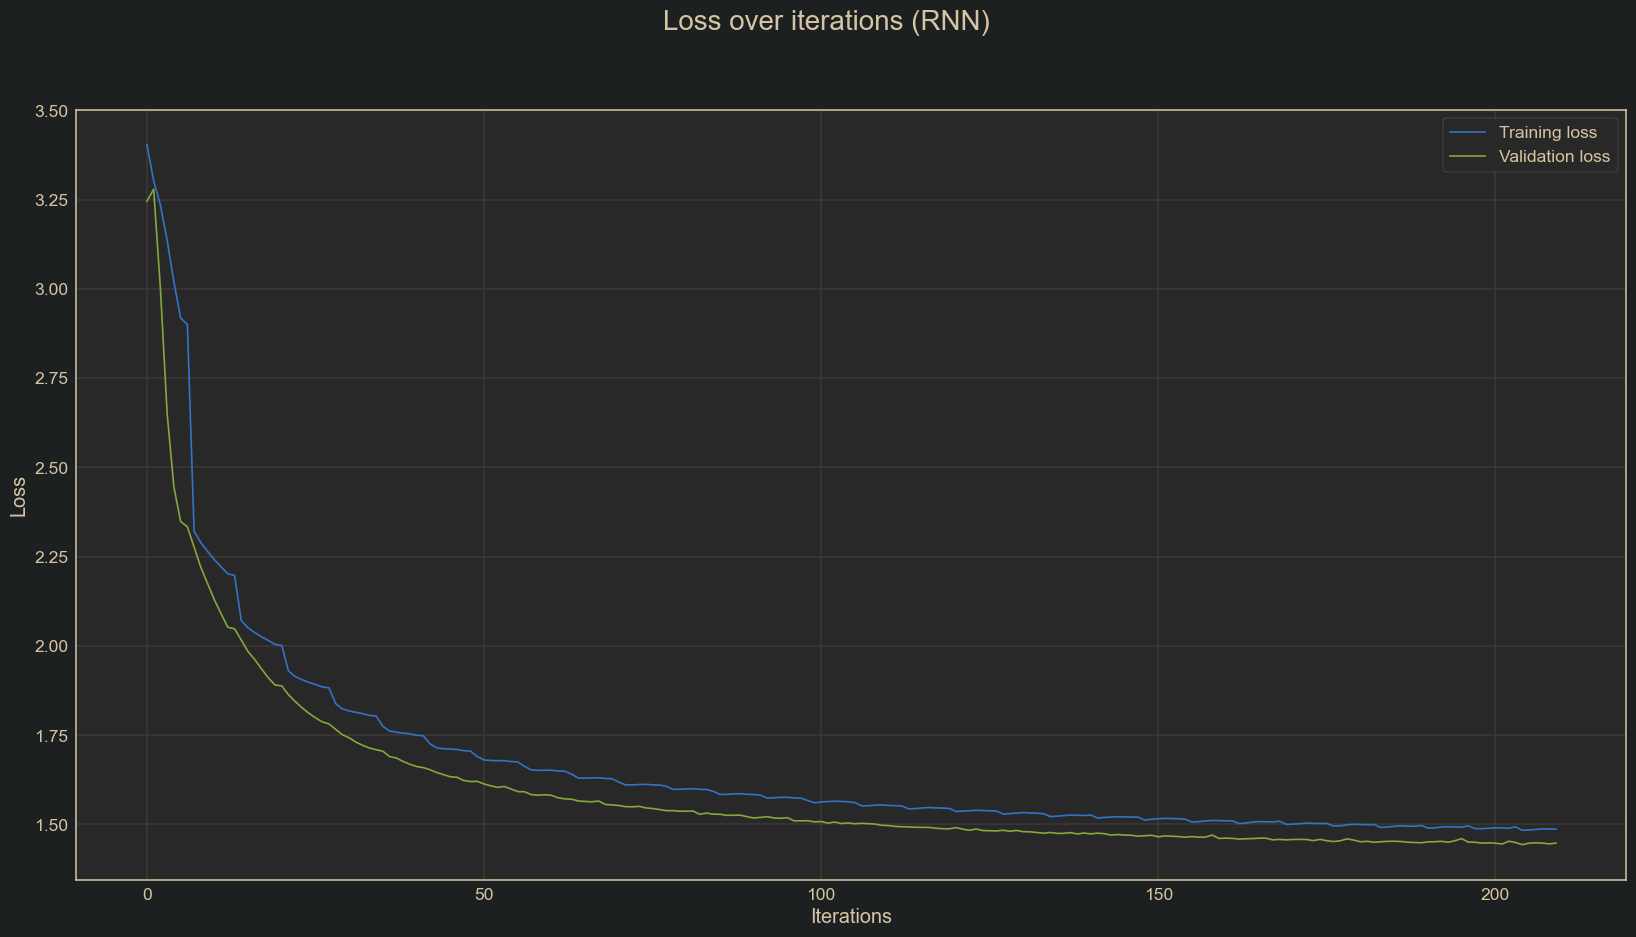

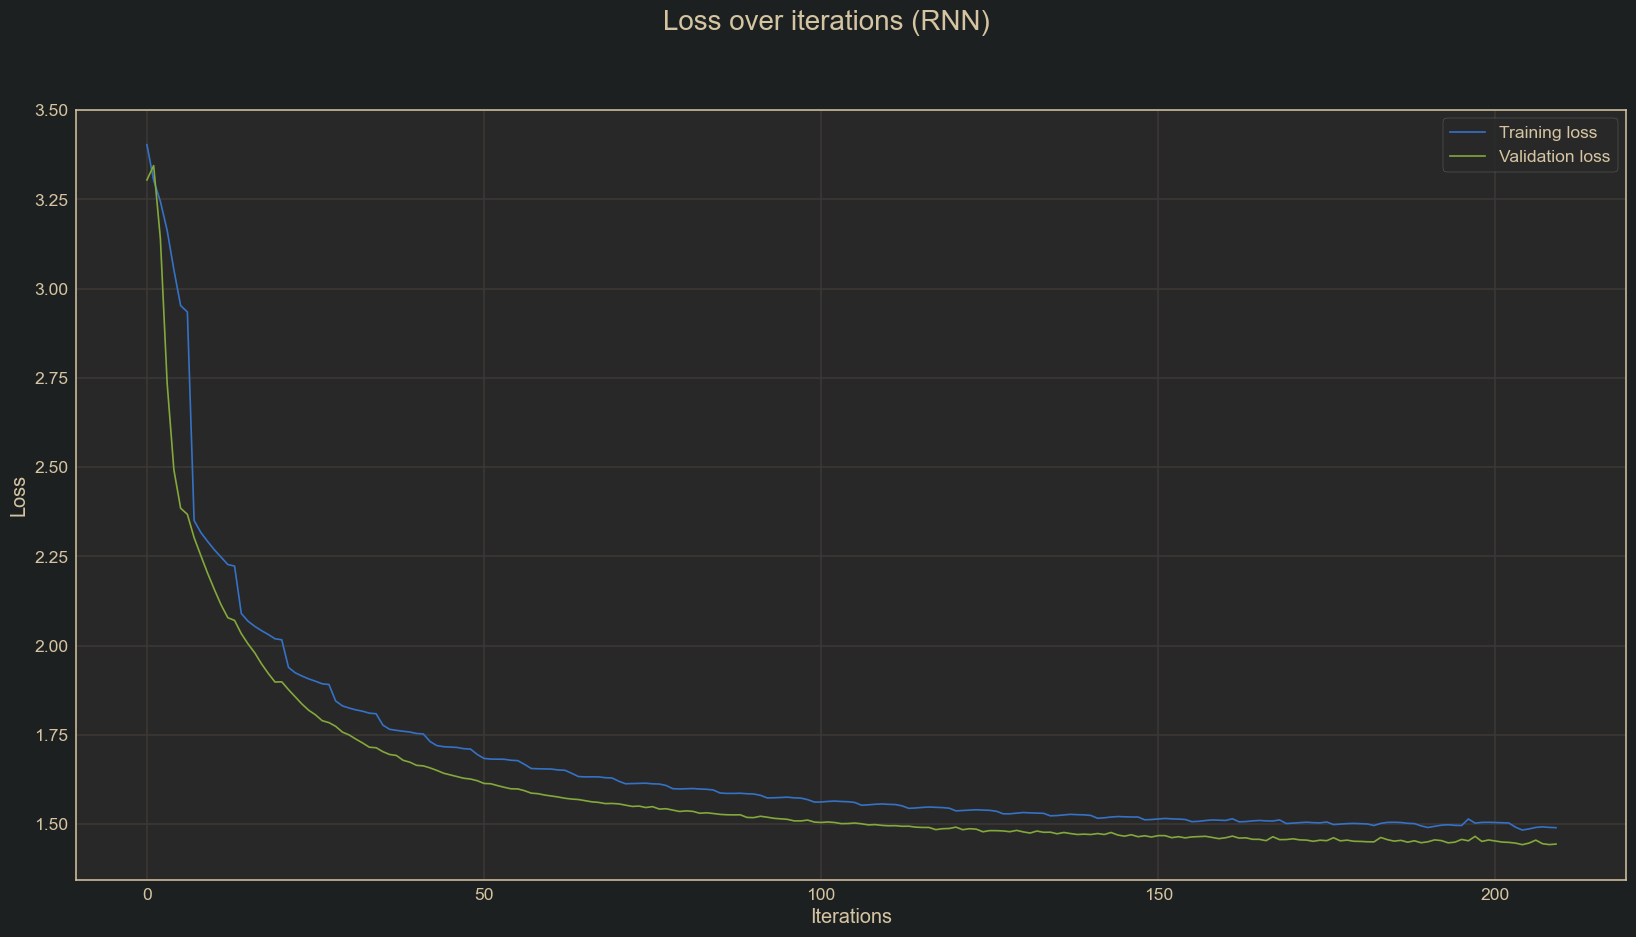

In [111]:
plt.figure(figsize = (20, 10))
plt.plot(range(len(running_train_loss)), running_train_loss, label = "Training loss")
plt.plot(range(len(running_val_loss)), running_val_loss, label = "Validation loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.suptitle("Loss over iterations (RNN)", fontsize = 20)
plt.legend()
plt.show(); plt.close("all")

In [112]:
### Freeze model weights
model.requires_grad_ = False

In [113]:
int2char = encoding_results.int2char
char2int = encoding_results.char2int

In [114]:
seed = "Lan al'Mandragoran went up the mountain"
k = 5

In [115]:
def predict(x, h, net, k = 5):
    x = np.array([[char2int[x]]])
    x = one_hot_encode(x, len(unique_chars))
    x = torch.from_numpy(x).to(device).contiguous()
    
    out, h = net(x, h)
    p = F.softmax(out, dim = -1).data
    p, chars = p.topk(k, dim=-1)
    
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    
    return np.random.choice(chars, p = p/p.sum()), h

In [116]:
h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_().to(device)
predict("D", h, model, 5)

(56,
 tensor([[[-0.2060, -0.1764,  0.2270,  ...,  0.3534, -0.0061, -0.1353]],
 
         [[ 0.3882,  0.0166,  0.9876,  ...,  0.9912, -0.8800,  0.3308]]],
        device='cuda:0', grad_fn=<CudnnRnnBackward0>))

(35,
 tensor([[[ 0.0182,  0.0649,  0.2790,  ...,  0.2906, -0.1961, -0.0911]],
 
         [[-0.2945, -0.7654,  0.3906,  ...,  0.9866, -0.9394,  0.5988]]],
        device='cuda:0', grad_fn=<CudnnRnnBackward0>))

In [117]:
def prime_model(model, seed, k):
    seed_list = list(seed)

    h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).to(device)
    if model.base_rnn == nn.LSTM:
        b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
        h = (h, b.to(device))

    for char in seed_list:
        h = tuple([each.data for each in h]) if type(h) == tuple else h.data
        next_char, h = predict(char, h, model, k)

    seed_list.append(int2char[next_char])

    return seed_list, h

seed_list = list(seed)

h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_().to(device)

for char in seed_list:
    h = h.data
    next_char, h = predict(char, h, model, k)

seed_list.append(int2char[next_char])
seed_list_1 = seed_list.copy()
seed_list_2 = seed_list.copy()

In [118]:
first_seed_list, h = prime_model(model, seed, k)

In [119]:
print(''.join(first_seed_list))

Lan al'Mandragoran went up the mountainl
Lan al'Mandragoran went up the mountaini


In [120]:
## Method 1
for ii in range(1000):
    h = h.data
    next_char, h = predict(first_seed_list[-1], h, model, k)
    first_seed_list.append(int2char[next_char])

In [121]:
seed = "Why would you imagine that"

second_seed_list, h = prime_model(model, seed, k)

In [122]:
## Method 2
for ix in range(1000):
    h = h.data
    x = np.array(char2int[second_seed_list[-1]]).reshape(1, -1)
    x = one_hot_encode(x, len(unique_char))
    x = torch.tensor(x).to(device)
    out, h = model(x, h)
    
    p = F.softmax(out, dim=-1)
    p, chars = p.topk(k = k, dim=-1)
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    second_seed_list.append(int2char[np.random.choice(chars, p = p/p.sum())])
    #next_char = chars[torch.distributions.Uniform(low = 0, high = k).sample().to(torch.int32).item()].item()
    #seed_list.append(int2char[next_char])
    

In [123]:
### First generated text sample
first_pred_text = ''.join(first_seed_list)

In [124]:
print(first_pred_text)

Lan al'Mandragoran went up the mountainlly still at was her farely carniture, and the propired. All the table, but she was answered ta the distincted with ander, as it heard the
right to himself and see him and his first
recalled the complical person hudility, and was at the bess to any heart sha could hava the meatirns, how he had said so late of at the bus at the
province. And his forese from the came to the same smile. The counner to be doing. The more thought what
was a straight at the
proper was thought he came to that seemed happiness than ever to her. But not a straight began to at him with a
fire the change. Seepe the country to the
painfel terting. He could
not tek brought her
engared at time at the tore about the more alone to
see you think to see as he detumed a deelin, and that wosk it out on him, but the door. "Why did you to geal her some and shistened through, he had not beet singing to the country, and there was an antices, sho this were and dilichlest
and waited at her

In [125]:
### Second generated text sample
second_pred_text = ''.join(second_seed_list)

In [126]:
print(second_pred_text)

Why would you imagine that they was this feeling that
he had to tork
on
them."

"What why has been so many oline, and that he was sayen, the starce that he
caund the sands in that proper to the trange and tell
midslous, whise heart didnn to be sould thind if the mans with the ching that his, and when they was in liver in to the colvnait hand and side of her his steps of the
peisarter. "I may not conselt
do nothing both on the best of a saring him.

"I have taken to a carriage the mund which the monty and the delight the sang a little giver at the sect more troubles of his face. He was a party was not," said that time, and there
was a laiground her, and was now the carring. The country was not intensity to her. He thought at the peasants that she was saying
her
tower, still more.".

"Oblonsky, who had some ofter he he felt. That she was not seen her.

"If see
that he had an arring the
same canthe he was not a stare
to be dinging
his ficulatly to be to breming to the
stopped by, and he
h